# MMSE Regressor

In [1]:
from math import ceil, floor
from matplotlib import pyplot as plt
from pandas import Series
import seaborn as sns
import statsmodels.api as sm

from read import *
from utils import *

In [2]:
# A. Load model
from pickle import load
with open('model_80feat.pkl', 'rb') as file:
    model = load(file)

In [9]:
# B. Get test data (KJPP)

FEATURES_SELECTED = ['Spectral#RelativePower#F3#gamma', 'Hjorth#Complexity#T3', 'Spectral#PeakFrequency#O1#beta3', 'Spectral#Entropy#Pz#beta1', 'Spectral#RelativePower#Cz#beta2', 'Spectral#Diff#P4#beta2', 'Spectral#Flatness#T5#alpha2', 'Spectral#PeakFrequency#Fz#beta3', 'Spectral#EdgeFrequency#T3#delta', 'PLI#Temporal(L)-Occipital(L)#beta1', 'Spectral#RelativePower#C4#delta', 'Spectral#PeakFrequency#F8#alpha1', 'Spectral#EdgeFrequency#Pz#gamma', 'Spectral#PeakFrequency#Cz#gamma', 'Spectral#Flatness#T6#gamma', 'Spectral#RelativePower#Fz#delta', 'Spectral#EdgeFrequency#Fz#beta3', 'Spectral#EdgeFrequency#F8#beta3', 'Spectral#Diff#Cz#gamma', 'Hjorth#Activity#C3', 'Spectral#RelativePower#Cz#delta', 'Spectral#RelativePower#Fp2#gamma', 'Spectral#Entropy#F7#theta', 'PLI#Temporal(L)-Parietal(L)#alpha2', 'Spectral#RelativePower#T4#beta1', 'Spectral#RelativePower#Cz#gamma', 'Hjorth#Activity#P4', 'Spectral#RelativePower#Fz#gamma', 'Spectral#RelativePower#P3#theta', 'Spectral#EdgeFrequency#O2#beta2', 'Spectral#Diff#C4#beta1', 'Spectral#RelativePower#C3#gamma', 'Spectral#RelativePower#P4#beta3', 'Spectral#PeakFrequency#Fp2#beta2', 'Spectral#EdgeFrequency#T3#theta', 'Spectral#RelativePower#Fp1#beta1', 'Hjorth#Mobility#Pz', 'Spectral#RelativePower#Fpz#gamma', 'Spectral#Diff#T4#beta1', 'Spectral#Entropy#P3#alpha1', 'Spectral#Flatness#F4#beta2', 'Spectral#Entropy#F4#beta2', 'Spectral#RelativePower#C4#gamma', 'Spectral#RelativePower#Cz#beta3', 'Spectral#RelativePower#O1#alpha2', 'Spectral#PeakFrequency#Fz#gamma', 'Spectral#PeakFrequency#F4#delta', 'Spectral#RelativePower#P4#alpha1', 'Spectral#PeakFrequency#P3#gamma', 'Spectral#RelativePower#O2#beta3', 'Hjorth#Mobility#P4', 'Hjorth#Complexity#Fp2', 'Spectral#Diff#P3#beta1', 'Spectral#RelativePower#C3#beta1', 'Spectral#EdgeFrequency#Cz#beta3', 'Spectral#Diff#C3#theta', 'Spectral#RelativePower#Fp1#beta2', 'Spectral#EdgeFrequency#F4#delta', 'Spectral#RelativePower#P3#beta3', 'Spectral#RelativePower#F3#theta', 'Spectral#Entropy#O2#delta', 'Spectral#PeakFrequency#C4#beta1', 'Spectral#EdgeFrequency#Cz#gamma', 'Spectral#RelativePower#T6#beta1', 'Spectral#PeakFrequency#O2#theta', 'Spectral#Flatness#C4#gamma', 'Spectral#PeakFrequency#F7#gamma', 'Spectral#RelativePower#F7#gamma', 'Spectral#Diff#T5#beta1', 'Spectral#EdgeFrequency#Pz#beta3', 'Spectral#RelativePower#T3#beta3', 'Spectral#RelativePower#T4#gamma', 'Spectral#EdgeFrequency#F3#theta', 'Spectral#RelativePower#Fp2#beta1', 'Spectral#PeakFrequency#Fz#theta', 'Hjorth#Complexity#T5', 'Hjorth#Complexity#T4', 'Hjorth#Complexity#F8', 'Hjorth#Mobility#Cz', 'Spectral#PeakFrequency#Fp2#alpha1']

# 1) Get features
features = read_all_features('KJPP')
features = features[FEATURES_SELECTED]
print("Number of features selected:", len(features.columns))

# 2) Get targets
y = Series()
ages = read_ages('KJPP')
for session in features.index:
    try:
        age = ages[session]
        y.loc[session] = age
    except KeyError:
        continue

# Drop nans in y
y = y.dropna()
features = features.loc[y.index]

# 3) Normalise feature vectors between 0 and 1
features = feature_wise_normalisation(features, 'min-max')

# 4) Convert to an appropriate format
feature_names = features.columns.to_numpy()
sessions = features.index.to_numpy()
X = [features.loc[code].to_numpy() for code in sessions]

print("Number of samples:", len(X))
print("Number of features:", len(X[0]))

Number of features selected: 80


/var/folders/1g/sc9mrb8x18s7r9d97p9glqch0000gp/T/ipykernel_13651/2927572668.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y = Series()


Number of samples: 1701
Number of features: 80


(1701,)
(1701,)


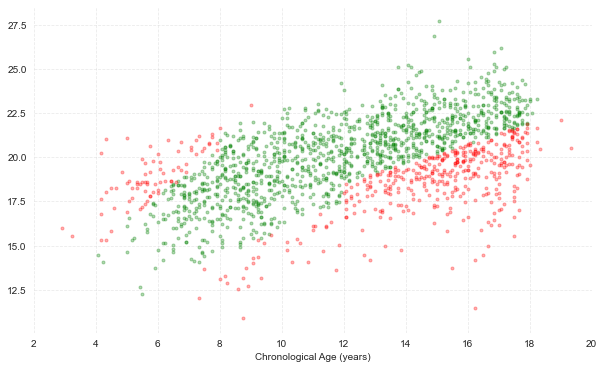

In [10]:
# C. Predictions
yhat = model.predict(X)
print(yhat.shape)
print(y.shape)

def is_good_developmental_age_estimate(age: float, mmse: int, margin:float=0) -> bool:
    """
    Checks if the MMSE estimate is within the acceptable range for the given age.
    A margin can be added to the acceptable range.
    """
    assert 0 <= mmse <= 30, "MMSE must be between 0 and 30"
    assert 0 <= age, f"Developmental age estimate must be positive. It is {age}."

    if age < 1.25:
        return 0 - margin <= mmse <= age / 2 + margin
    elif age < 2:
        return floor((4 * age / 15) - (1 / 3)) - margin <= mmse <= ceil(age / 2) + margin
    elif age < 5:
        return (4 * age / 15) - (1 / 3) - margin <= mmse <= 2 * age + 5 + margin
    elif age < 7:
        return 2 * age - 6 - margin <= mmse <= (4 * age / 3) + (25 / 3) + margin
    elif age < 8:
        return (4 * age / 5) + (47 / 5) - margin <= mmse <= (4 * age / 3) + (25 / 3) + margin
    elif age < 12:
        return (4 * age / 5) + (47 / 5) - margin <= mmse <= (4 * age / 5) + (68 / 5) + margin
    elif age < 13:
        return (4 * age / 7) + (92 / 7) - margin <= mmse <= (4 * age / 5) + (68 / 5) + margin
    elif age < 19:
        return (4 * age / 7) + (92 / 7) - margin<= mmse <= 30 + margin
    elif age >= 19:
        return mmse - margin >= 29 + margin

accurate = []
inaccurate = []
for prediction, age in zip(yhat, y):
    if is_good_developmental_age_estimate(age, prediction, margin=1.5):
        accurate.append((age, prediction))
    else:
        inaccurate.append((age, prediction))

accurate_x, accurate_y = zip(*accurate)
inaccurate_x, inaccurate_y = zip(*inaccurate)

# 9. Plot predictions vs targets
plt.figure(figsize=(10,6))
plt.xlabel('Chronological Age (years)')
plt.xlim(2, 20)
plt.grid(linestyle='--', alpha=0.4)
plt.scatter(accurate_x, accurate_y, color='g', marker='.', alpha=0.3)
plt.scatter(inaccurate_x, inaccurate_y, color='r', marker='.', alpha=0.3)
# remove box around plot
plt.box(False)
plt.show()

In [7]:
df = DataFrame({'y': y, 'yhat': yhat})
df.to_csv('predictions.csv', index=False)

In [15]:
# D. Linear Regression
reg = sm.OLS(y, sm.add_constant(yhat))
fit = reg.fit()

## 1. Explanation of Variation
#### (using a least-squares regression line)

1.1. Coefficient of Determination (R^2)

In [16]:
fit.f_pvalue

3.072599351168361e-109

In [17]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     572.3
Date:                Tue, 23 Apr 2024   Prob (F-statistic):          3.07e-109
Time:                        17:05:58   Log-Likelihood:                -4531.9
No. Observations:                1701   AIC:                             9068.
Df Residuals:                    1699   BIC:                             9079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8755      0.727     -6.710      0.000      -6.301      -3.450
x1             0.8726      0.036     23.922      0.000       0.801       0.944
==============================================================================
Omnibus:                     1536.946   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205499.245
Skew:                           3.683   Prob(JB):                         0.00
Kurtosis:                      56.340   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
import scipy.stats
scipy.stats.spearmanr(y, yhat)

SpearmanrResult(correlation=0.5454838643845452, pvalue=1.76930877515253e-132)

1.2. Sum of squared errors of prediction, SSE

In [7]:
# doing the formula manually
sse = sum((y - yhat)**2)
sse

113754.35066173479

## 2. By Age Group

In [8]:
y1 = y[y < 5]
X1 = features.loc[y1.index]
y2 = y[(5 <= y) & (y < 10)]
X2 = features.loc[y2.index]
y3 = y[(10 <= y) & (y < 15)]
X3 = features.loc[y3.index]
y4 = y[y >= 15]
X4 = features.loc[y4.index]

In [9]:
# predictions in each age group
yhat1 = model.predict(X1)
yhat2 = model.predict(X2)
yhat3 = model.predict(X3)
yhat4 = model.predict(X4)

/Users/saraiva/PycharmProjects/IT-LongTermBiosignals/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/saraiva/PycharmProjects/IT-LongTermBiosignals/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/saraiva/PycharmProjects/IT-LongTermBiosignals/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/saraiva/PycharmProjects/IT-LongTermBiosignals/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


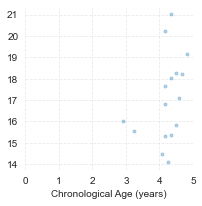

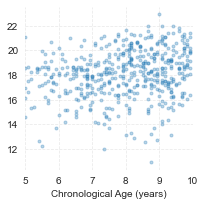

In [14]:
plt.figure(figsize=(3,3))
plt.xlabel('Chronological Age (years)')
plt.xlim(0, 5)
plt.grid(linestyle='--', alpha=0.4)
plt.scatter(y1, yhat1,marker='.', alpha=0.3)
# remove box around plot
plt.box(False)
plt.show()

plt.figure(figsize=(3,3))
plt.xlabel('Chronological Age (years)')
plt.xlim(5, 10)
plt.grid(linestyle='--', alpha=0.4)
plt.scatter(y2, yhat2,marker='.', alpha=0.3)
# remove box around plot
plt.box(False)
plt.show()

In [10]:
fit1 = sm.OLS(y1, yhat1).fit()
fit2 = sm.OLS(y2, yhat2).fit()
fit3 = sm.OLS(y3, yhat3).fit()
fit4 = sm.OLS(y4, yhat4).fit()

In [11]:
fit1.summary()

/Users/saraiva/PycharmProjects/IT-LongTermBiosignals/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              903.1
Date:                Tue, 23 Apr 2024   Prob (F-statistic):                    8.10e-15
Time:                        08:55:36   Log-Likelihood:                         -12.862
No. Observations:                  16   AIC:                                      27.72
Df Residuals:                      15   BIC:                                      28.50
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2442      0.008     30.052      0.000       0.227       0.262
==============================================================================
Omnibus:                        1.589   Durbin-Watson:                   2.369
Prob(Omnibus):                  0.452   Jarque-Bera (JB):                1.252
Skew:                          -0.518   Prob(JB):                        0.535
Kurtosis:                       2.102   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.599e+04
Date:                Tue, 23 Apr 2024   Prob (F-statistic):                        0.00
Time:                        08:57:28   Log-Likelihood:                         -862.42
No. Observations:                 493   AIC:                                      1727.
Df Residuals:                     492   BIC:                                      1731.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4363      0.003    126.457      0.000       0.430       0.443
==============================================================================
Omnibus:                        2.610   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.246
Skew:                          -0.060   Prob(JB):                        0.325
Kurtosis:                       2.691   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

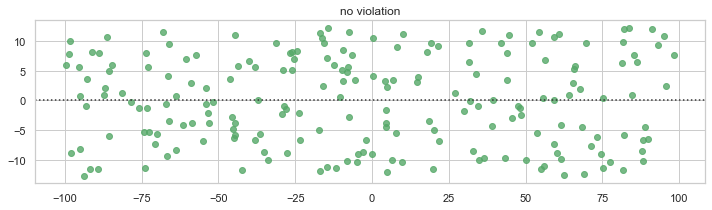

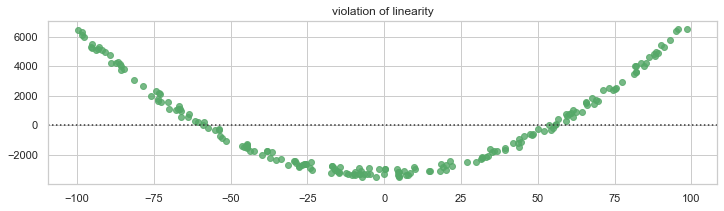

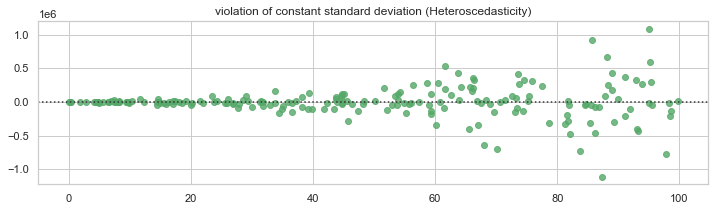

In [16]:
import numpy as np

sns.set_theme(style="whitegrid")

rs = np.random.RandomState(7)
n = 200
x = rs.uniform(-100, 100, n)
y_1 = 5 * x + rs.uniform(0, 25, n)
y_2 = x ** 2 + rs.uniform(0, 25**2, n)

def h(x):
    return 100+.5*x**2
# eps = abs(rs.normal(0, h(x), n))

eps = np.arange(0, n)*h(x)

y_3 = 4*abs(x) + rs.normal(25, eps, n)

fig1 = plt.figure(figsize=(12, 3))
sns.residplot(x=x, y=y_1, color="g")
plt.title("no violation")
plt.show()

fig2 = plt.figure(figsize=(12, 3))
sns.residplot(x=x, y=y_2, color="g")
plt.title("violation of linearity")
plt.show()

fig3 = plt.figure(figsize=(12, 3))
sns.residplot(x=abs(x), y=y_3, color="g")
plt.title("violation of constant standard deviation (Heteroscedasticity)")
plt.show()

In [ ]:
fig = sm.qqplot(df['y_1'], line ='45')
plt.show()

fig = sm.qqplot(df['y_2'], line ='45')
plt.show()

fig = sm.qqplot(df['y_3'], line ='45')
plt.show()